In [1]:
!git clone https://github.com/Oliverluyu/brain_tumor_img_segmentation.git
%cd brain_tumor_img_segmentation
!git checkout experiment2


Cloning into 'brain_tumor_img_segmentation'...
remote: Enumerating objects: 13164, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13164 (delta 3), reused 10 (delta 3), pack-reused 13149
Receiving objects: 100% (13164/13164), 505.57 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (557/557), done.
Updating files: 100% (15653/15653), done.
/content/brain_tumor_img_segmentation
Branch 'experiment2' set up to track remote branch 'experiment2' from 'origin'.
Switched to a new branch 'experiment2'


# training classification

Epoch 1/20, Training Loss: 0.6155, Validation Loss: 1.0576, Validation Accuracy: 68.81%
Epoch 2/20, Training Loss: 0.4261, Validation Loss: 0.3772, Validation Accuracy: 88.96%
Epoch 3/20, Training Loss: 0.3436, Validation Loss: 0.6807, Validation Accuracy: 71.00%
Epoch 4/20, Training Loss: 0.2994, Validation Loss: 0.3245, Validation Accuracy: 88.11%
Epoch 5/20, Training Loss: 0.2787, Validation Loss: 0.6175, Validation Accuracy: 77.43%
Epoch 6/20, Training Loss: 0.2294, Validation Loss: 0.2588, Validation Accuracy: 91.75%
Epoch 7/20, Training Loss: 0.2064, Validation Loss: 0.4088, Validation Accuracy: 85.80%
Epoch 8/20, Training Loss: 0.1834, Validation Loss: 0.7547, Validation Accuracy: 73.91%
Epoch 9/20, Training Loss: 0.1701, Validation Loss: 0.2619, Validation Accuracy: 89.32%
Epoch 10/20, Training Loss: 0.1459, Validation Loss: 0.9063, Validation Accuracy: 76.58%
Epoch 11/20, Training Loss: 0.1351, Validation Loss: 0.3969, Validation Accuracy: 86.65%
Epoch 12/20, Training Loss: 0.

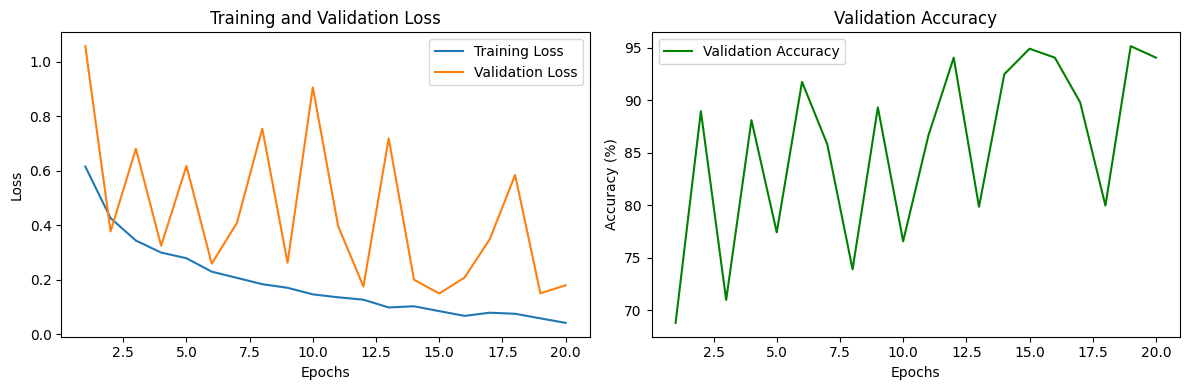

Epoch [1/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [2/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [3/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [4/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [5/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [6/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [7/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [8/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [9/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [10/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [11/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [12/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [13/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [14/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [15/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [16/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [17/20], Test Loss: 0.1127, Test Accuracy: 94.05%
Epoch [18/20], Test Loss: 0.1127, Test Accuracy: 94.05%
E

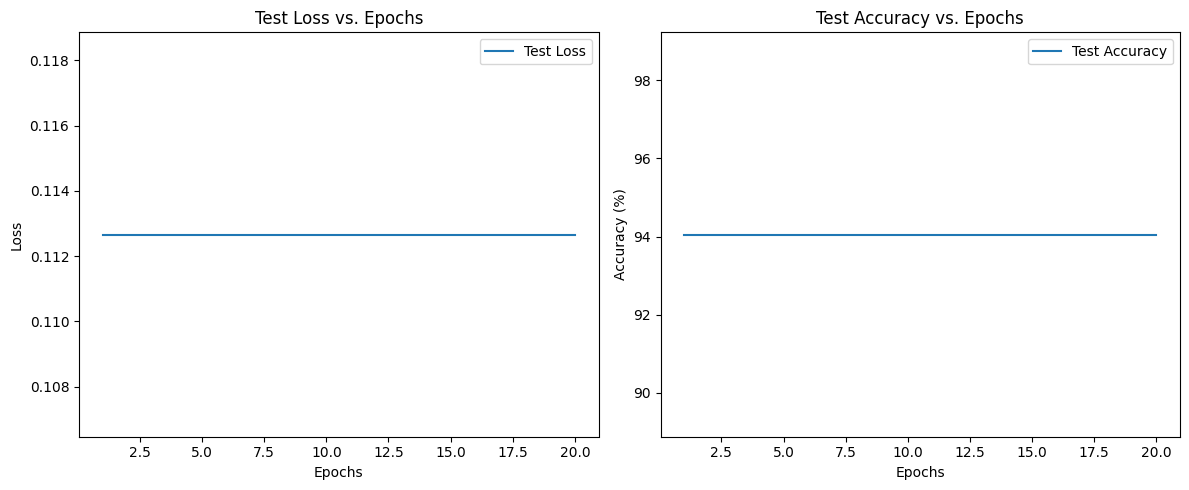

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.network_helper import init_weights
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from models.VanillaUnet import unet_2D
import matplotlib.pyplot as plt


# Define dataset directory
dataset_dir = r'datasets/classification/'
# Define batch size and image dimensions
batch_size = 32
image_size = 256

# Define data transformations for grayscale images
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((image_size, image_size)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# Load sampled dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = ImageFolder(root=os.path.join(dataset_dir, 'validation'), transform=data_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=data_transforms)
test_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Define VanillaUnet model
# 4 classes for the classification task (e.g., glioma, meningioma, notumor, pituitary)
# Change the 'in_channels' to 1 for grayscale images
model = unet_2D(in_channels=1, n_classes=4, mode='classification')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store metrics
epoch_losses = []
val_epoch_losses = []
val_epoch_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs, reconstructions = model(images)
        loss = criterion(outputs, labels)
        loss += 0.5 * torch.mean((reconstructions - images)**2)  # Reconstruction loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_losses.append(val_epoch_loss)
    val_accuracy = 100 * correct / total
    val_epoch_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plotting the metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.plot(epochs, val_epoch_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_epoch_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


# # Once training is complete, evaluate on test set
# test_loss = 0
# test_running_loss = 0
# test_accuracy = 0
# total = 0
# correct = 0  # Ensure these are reset before the test loop
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs, _ = model(images)
#         test_loss = criterion(outputs, labels)
#         test_running_loss += test_loss.item() * images.size(0)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#     test_loss = test_running_loss / len(test_dataset)  # Corrected to use test_dataset
#     test_accuracy = 100 * correct / total
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")  # Print test accuracy and loss


test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Your training loop code goes here

    # Once training for an epoch is complete, evaluate on test set
    model.eval()  # Set model to evaluation mode
    test_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            test_loss = criterion(outputs, labels)
            test_running_loss += test_loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_test_loss = test_running_loss / len(test_dataset)
        epoch_test_accuracy = 100 * correct / total

        # Store metrics
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%")

epochs = range(1, num_epochs + 1)

# Plotting test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Test Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'saved_models/classification_model_20epochs.pth')